# Reconstructing Artistic Representations Using Masked Auto-Encoders (MAEs) 

This project aims to re-implement a Masked Autoencoder (MAE), a self-supervised learning framework introduced by He et al. (2021). MAEs learn meaningful visual representations by reconstructing images from partially masked inputs, forcing the model to infer missing content from context. While MAEs are shown scalable on natural images, their applicability to artistic paintings, where brushstrokes, color palettes, and composition carry artistic intent, remains unexplored. Unlike photographs, paintings are constructed rather than captured, raising the question: Can MAEs learn meaningful representations of artistic intent? By ablating masking strategies (random vs. stroke-aware masking) and measuring image reconstruction, we evaluate whether MAEs are applicable to the art domain.

# Getting Started

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

from einops import rearrange
from timm.models.vision_transformer import Block

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

from utils import WikiArtDataset

import warnings
warnings.filterwarnings('ignore')

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {DEVICE}")

using device: cuda


In [3]:
DATASET_PATH = "data\WikiArtDataset.zip"
DATASET_PREVIEWS_PATH = "data\WikiArtDataset_Previews"

MODEL_1_PATH = "models/mae_1_epoch_11.pt"
MODEL_2_PATH = "models/mae_2_epoch_13.pt"
MODEL_3_PATH = "models/mae_3_epoch_9.pt"

# Wiki Art Dataset

We will be employing the [Wiki-Art : Visual Art Encyclopedia](https://www.kaggle.com/datasets/ipythonx/wikiart-gangogh-creating-art-gan?resource=download) sourced by Innat on Kaggle. This imageset is composed of artworks scraped from [WikiArt.org](WikiArt.org), providing various types of art styles,

- `abstract`: 14999 counts
- `animal-painting`: 1798
- `cityscape`: 6598
- `figurative`: 4500
- `flower-painting`: 1800
- `genre-painting`: 14997
- `landscape`: 15000
- `marina`: 1800
- `mythological-painting`: 2099
- `nude-painting-nu`: 3000
- `portrait`: 14999
- `religious-painting`: 8400
- `still-life`: 2996
- `symbolic-painting`: 299

The MAE model will be trained, validated, and tested on a combined and shuffled dataset of these images. Hopefully, we can expect consistent results across all the art contexts. 

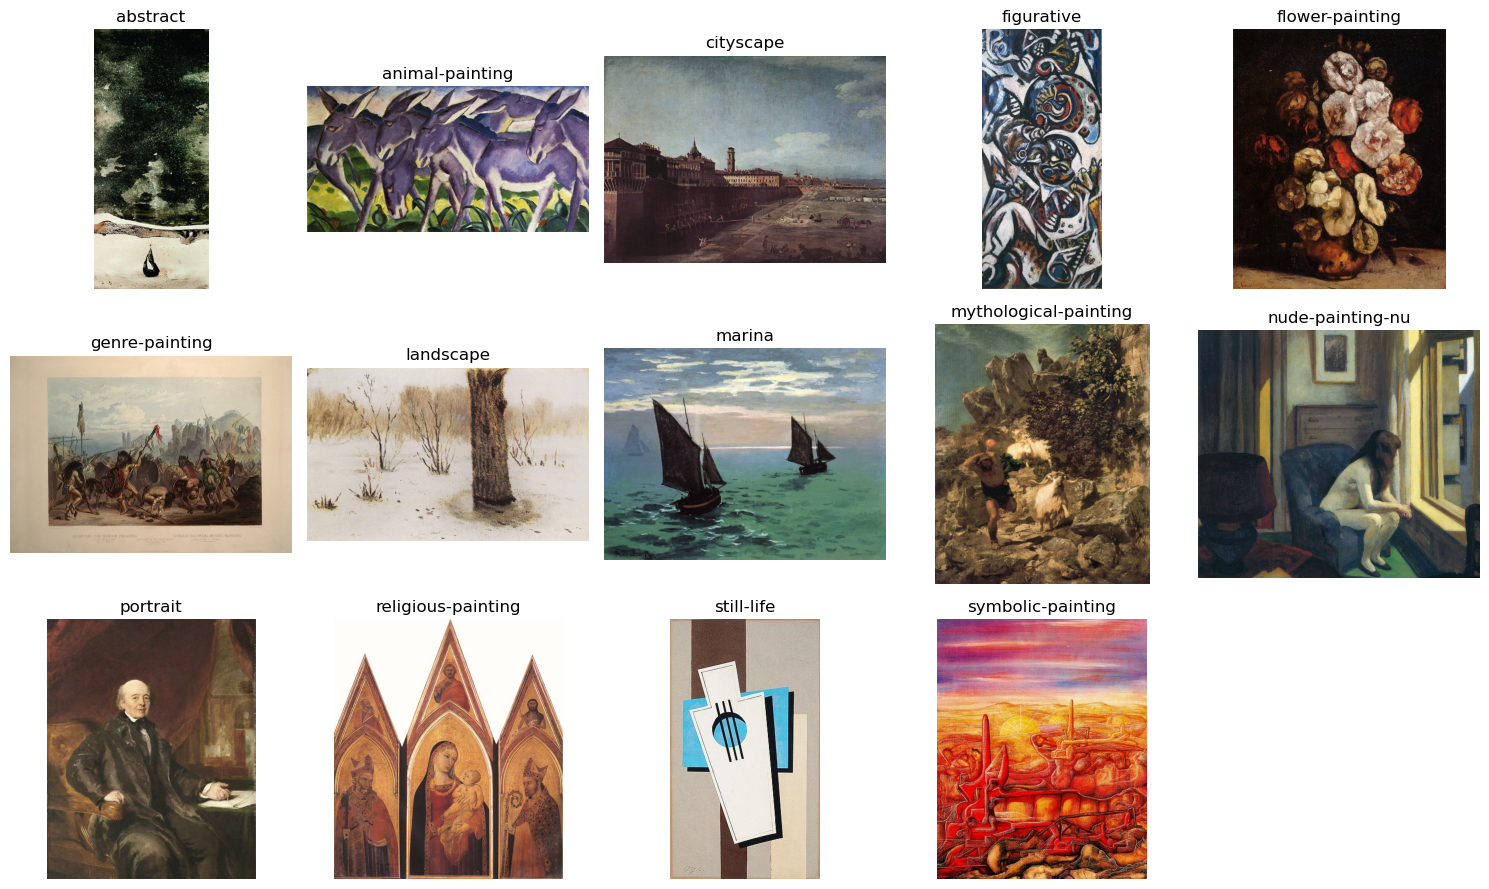

In [4]:
# Preview examples
preview_images = os.listdir(DATASET_PREVIEWS_PATH)

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

axes = axes.ravel()

for i, (ax, image_file) in enumerate(zip(axes, preview_images)):
    image_path = os.path.join(DATASET_PREVIEWS_PATH, image_file)
    image = Image.open(image_path)
    image_art_type = image_file.split(".")[0]
    
    ax.imshow(image)
    ax.set_title(f"{image_art_type}")
    ax.axis('off')

# Turn off any remaining empty subplots
for j in range(len(preview_images), 3*5):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Create dataloaders
BATCH_SIZE = 32
NUM_WORKERS = 4

TRAIN_SPLIT = 0.7
VALID_SPLIT = 0.15
TEST_SPLIT = 0.15

transforms = T.Compose(
    [
        T.Resize((224, 224)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomGrayscale(p=0.1),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
)

In [41]:
full_wiki_art_dataset = WikiArtDataset(DATASET_PATH, transform=transforms)

# Split training set
train_size = int(0.8 * len(full_wiki_art_dataset))
temp_size = len(full_wiki_art_dataset) - train_size
train_dataset, temp_dataset = random_split(
    full_wiki_art_dataset, 
    [train_size, temp_size]
)

# Split validation and test set
val_size = int(0.5 * len(temp_dataset))
test_size = len(temp_dataset) - val_size
val_dataset, test_dataset = random_split(
    temp_dataset, 
    [val_size, test_size]
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

# Final MAE Implementation

This is an outlined workflow of the training and testing process of the MAE,

1. Masking:
    - For each input image, divide them into patches and randomly select 75% of the patches to mask
2. Encoding:
    - Pass only the visible patches through the encoder
    - The output should be the latent representations for each unmasked patch
3. Decoding:
    - The decoder takes in the encoded masked patches (output of the encoder) and Mask tokens (learnable placeholders for masked patches)
    - Goal is to reconstruct all patches of the input image, including visible patches

![architecture](imgs/architecture.png)

### Input Masking

In a MAE, input images are instead masked or "patched out" from the model during training. Masking is performed by splitting the images into fixed sized patches and randomly selecting 75% of the patches to mask. The motivation of this to not only reconstruct the missing parts of a masked image but to also force the model to learn meaningful representations.

In [7]:
class PatchMasker(nn.Module):
    def __init__(self, mask_ratio=0.75, patch_size=16):
        super().__init__()
        
        self.mask_ratio = mask_ratio
        self.patch_size = patch_size

    def forward(self, x):
        B, C, H, W = x.shape

        # Split into patches
        x_patches = rearrange(
            x,
            'b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
            p1=self.patch_size,
            p2=self.patch_size
        )
        num_patches = x_patches.shape[1]

        # Generate random mask
        noise = torch.rand(B, num_patches, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)

        # Get masked/unmasked indices
        num_masked = int(num_patches * self.mask_ratio)
        mask_indices = ids_shuffle[:, :num_masked]
        unmasked_indices = ids_shuffle[:, num_masked:]

        return x_patches, mask_indices, unmasked_indices

In [8]:
# Simulate patch masker
test_image = Image.open("data\WikiArtDataset_Previews\symbolic-painting.jpg").convert('RGB')
test_image = transforms(image).unsqueeze(0)

test_mask_ratio = 0.25
test_patch_size = 16

masker = PatchMasker(mask_ratio=test_mask_ratio, patch_size=test_patch_size)
patches, mask_indices, unmasked_indices = masker(test_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


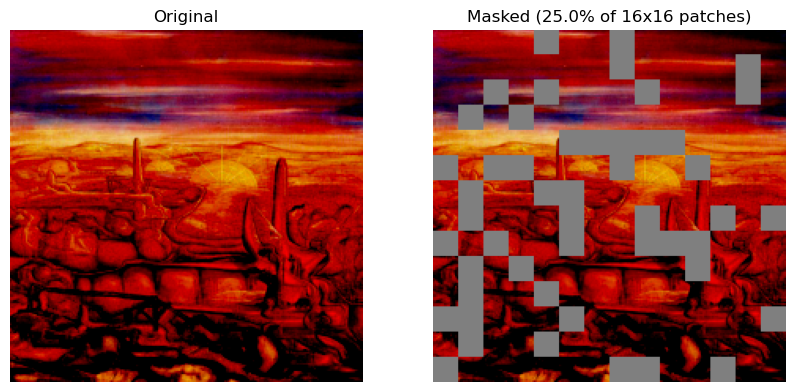

In [9]:
# Create visualization (replace masked patches with gray)
masked_patches = patches.clone()
masked_patches[0, mask_indices[0]] = 0.5

# Reconstruct image from patches
B, C, H, W = test_image.shape
masked_image = rearrange(
    masked_patches,
    'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
    h=H//16,
    w=W//16,
    p1=16,
    p2=16,
    c=C
)

# Visualize side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image[0].permute(1, 2, 0))
plt.title("Original")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masked_image[0].permute(1, 2, 0))
plt.title(f"Masked ({100*test_mask_ratio}% of {test_patch_size}x{test_patch_size} patches)")
plt.axis('off')

plt.show()

### Base MAE

In [10]:
class MAE_Encoder(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channels=3, embed_dim=768, num_layers=12, num_heads=12):
        super().__init__()

        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2

        # Patch embedding
        self.patch_embed = nn.Linear(patch_size**2 * in_channels, embed_dim)

        # Positional embeddings and CLS token
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim, dtype=torch.float32))
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim, dtype=torch.float32))

        # Transformer
        self.blocks = nn.Sequential(*[Block(embed_dim, num_heads) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(embed_dim)

        self.initialize_weights()

    def initialize_weights(self):
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

    def forward(self, x_patches, unmasked_indices):
        batch_size = x_patches.shape[0]

        # Extract unmasked patches
        x_unmasked = torch.stack([
            x_patches[i, unmasked_indices[i]] for i in range(batch_size)
        ], dim=0)

        x_unmasked = self.patch_embed(x_unmasked)

        # Add positional embeddings
        pos_embed = self.pos_embed[:, 1:].expand(batch_size, -1, -1)
        pos_embed_unmasked = torch.stack([
            pos_embed[i, unmasked_indices[b]] for i in range(batch_size)
        ], dim=0
            
        x_unmasked = x_unmasked + pos_embed_unmasked.to(x_unmasked.dtype)

        # Append cls token
        cls_token = self.cls_token.expand(batch_size, -1, -1).to(x_unmasked.dtype)
        x_unmasked = torch.cat([cls_token, x_unmasked], dim=1)

        # Transformer
        x_encoded = self.blocks(x_unmasked)
            
        return self.norm(x_encoded)

In [11]:
class MAE_Decoder(nn.Module):
    def __init__(self, image_size=224, patch_size=16, in_channels=3, encoder_embed_dim=768, decoder_embed_dim=512, num_layers=4, num_heads=8):
        super().__init__()

        self.num_patches = (image_size // patch_size) ** 2
        self.decoder_embed = nn.Linear(encoder_embed_dim, decoder_embed_dim)

        # Positional embeddings, mask token
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, decoder_embed_dim, dtype=torch.float32))
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim, dtype=torch.float32))

        # Decoder transformer
        self.blocks = nn.Sequential(*[Block(decoder_embed_dim, num_heads) for _ in range(num_layers)])
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_channels)

        self.initialize_weights()

    def initialize_weights(self):
        nn.init.trunc_normal_(self.mask_token, std=0.02)
        nn.init.trunc_normal_(self.decoder_pos_embed, std=0.02)

    def forward(self, x_encoded, mask_indices, unmasked_indices):
        batch_size = x_encoded.shape[0]

        # Project encoder output
        x_decoder = self.decoder_embed(x_encoded)

        # Reconstructed image
        x_full = torch.zeros(
            batch_size,
            self.num_patches + 1,
            x_decoder.shape[-1],
            dtype=x_decoder.dtype,
        )

        # Set CLS token
        x_full[:, 0] = x_decoder[:, 0]

        # Set unmasked patch tokens
        for i in range(batch_size):
            x_full[i, unmasked_indices[i] + 1] = x_decoder[i, 1:]

        # Insert mask tokens
        mask_tokens = self.mask_token.expand(batch_size, mask_indices.shape[1], -1).to(x_decoder.dtype)
        for i in range(batch_size):
            x_full[i, mask_indices[i] + 1] = mask_tokens[i]

        # Add positional embeddings
        x_full = x_full + self.decoder_pos_embed[:, :x_full.size(1)].to(x_full.dtype)

        # Transformer and prediction
        x_decoded = self.blocks(x_full)
        pred_patches = self.decoder_pred(x_decoded[:, 1:])
        
        return pred_patches

In [12]:
class MAE(nn.Module):
    def __init__(
        self,
        image_size=224, 
        patch_size=16, 
        in_channels=3,
        encoder_embed_dim=256,
        decoder_embed_dim=128,
        encoder_depth=4,
        decoder_depth=1,
        encoder_heads=4,
        decoder_heads=2,
        mask_ratio=0.75,
    ):
        super().__init__()
        
        self.mask_ratio = mask_ratio
        self.patch_size = patch_size
        self.image_size = image_size

        self.patch_masker = PatchMasker(mask_ratio, patch_size)
        self.encoder = MAE_Encoder(
            image_size=image_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=encoder_embed_dim,
            num_layers=encoder_depth,
            num_heads=encoder_heads,
        )
        self.decoder = MAE_Decoder(
            image_size=image_size,
            patch_size=patch_size,
            in_channels=in_channels,
            encoder_embed_dim=encoder_embed_dim,
            decoder_embed_dim=decoder_embed_dim,
            num_layers=decoder_depth,
            num_heads=decoder_heads,
        )

    def forward(self, x):
        x_patches, mask_indices, unmasked_indices = self.patch_masker(x)
        x_encoded = self.encoder(x_patches, unmasked_indices)
        predicted_patches = self.decoder(x_encoded, mask_indices, unmasked_indices)

        predicted_image = rearrange(
            predicted_patches,
            'b (h w) (p1 p2 c) -> b c (h p1) (w p2)',
            h=int((x.shape[2] / self.patch_size)),
            w=int((x.shape[3] / self.patch_size)),
            p1=self.patch_size,
            p2=self.patch_size,
            c=x.shape[1],
        )

        B, C, H, W = x.shape
        num_patches = (H // self.patch_size) * (W // self.patch_size)
        
        mask = torch.ones(B, num_patches)
        mask.scatter_(1, unmasked_indices, 0)
        
        # Reshape to spatial dimensions
        mask = mask.reshape(B, 1, H // self.patch_size, W // self.patch_size)
        mask = F.interpolate(mask.float(), size=(H, W), mode='nearest')

        return predicted_image, mask

In [13]:
# Load model 1
model_1 = MAE(
    encoder_embed_dim=384,
    decoder_embed_dim=256,
    encoder_depth=6,
    decoder_depth=2,
    encoder_heads=6,
    decoder_heads=4,
).cuda()

checkpoint = torch.load(MODEL_1_PATH)
model_1.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Evaluate Base MAE

In [14]:
def evaluate_MAE(model, data_loader):
    model.eval()
    total_loss = 0.0
    total_pixels = 0

    criterion = torch.nn.MSELoss(reduction='sum').cuda()

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating", leave=False)
        
        for images in progress_bar:
            images = images[0].cuda(non_blocking=True)

            predicted_img, mask = model(images)
            loss = criterion(predicted_img * mask, images * mask)

            total_loss += loss.item()
            total_pixels += mask.sum().item()
            
            progress_bar.set_postfix({
                'batch_loss': loss.item() / mask.sum().item(),
                'avg_loss': total_loss / total_pixels if total_pixels > 0 else 0
            })

    avg_loss = total_loss / total_pixels if total_pixels > 0 else 0
    
    return avg_loss

In [43]:
_cached_reconstruction_images = None

In [44]:
def show_reconstructions(model, data_loader, num_images=3):
    global _cached_reconstruction_images
    
    model.eval()
    
    if _cached_reconstruction_images is None:
        images, _ = next(iter(data_loader))
        _cached_reconstruction_images = images[:num_images]
    
    images = _cached_reconstruction_images.cuda(non_blocking=True)
    
    with torch.no_grad():
        reconstructions, masked_indices = model(images)
    
    # Convert to numpy and properly format
    original_imgs = images.cpu().numpy()
    mask = masked_indices.cpu().numpy()

    grey_value = 0.5
    masked_imgs = original_imgs.copy()
    masked_imgs = masked_imgs * (1 - mask) + grey_value * mask
    recon_imgs = reconstructions.cpu().numpy()
    
    plt.figure(figsize=(10, 7))
    for i in range(num_images):
        # Original image
        plt.subplot(3, num_images, i + 1)
        plt.imshow(np.transpose(original_imgs[i], (1, 2, 0)))
        plt.title(f"Original {i+1}")
        plt.axis('off')
        
        # Masked image
        plt.subplot(3, num_images, i + num_images + 1)
        plt.imshow(np.transpose(masked_imgs[i], (1, 2, 0)))
        plt.title(f"Masked {i+1}")
        plt.axis('off')
        
        # Reconstructed image
        plt.subplot(3, num_images, i + 2 * num_images + 1)
        plt.imshow(np.transpose(recon_imgs[i], (1, 2, 0)))
        plt.title(f"Reconstructed {i+1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [17]:
val_loss = evaluate_MAE(model_1, val_loader)

print(f"Validation Loss (MSE on masked regions): {val_loss:.4f}")

Validation Loss (MSE on masked regions): 0.1943


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


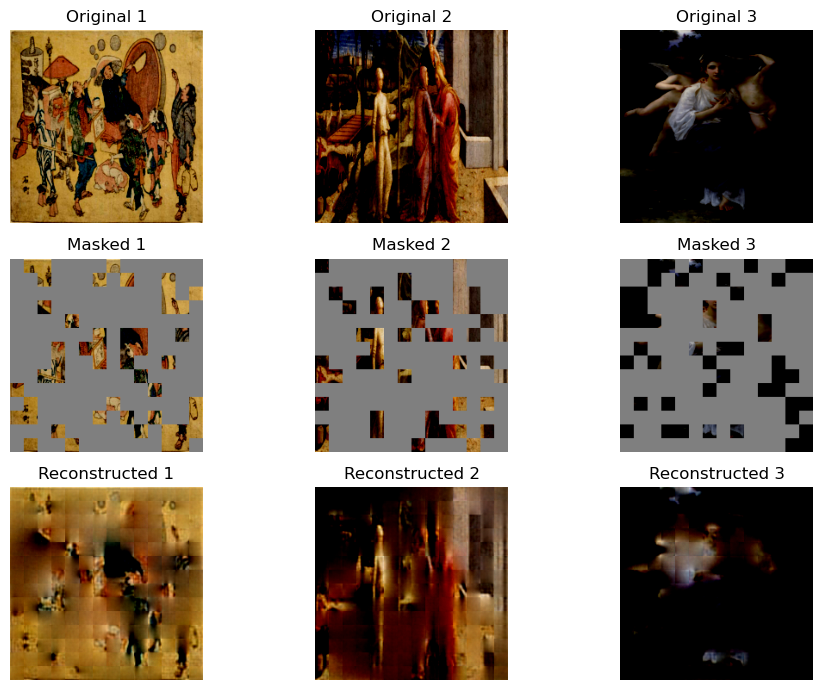

In [45]:
show_reconstructions(model_1, val_loader, num_images=3)

# Other Experimental MAE Implementations

### MAE Model 2 (Implemented in `MAE_model_2.ipynb`)

In [19]:
from models.MAE_model_2 import MAE as MAE_MODEL_2

In [20]:
# load model 2
model_2 = MAE_MODEL_2().cuda()

checkpoint = torch.load(MODEL_2_PATH)
model_2.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [21]:
val_loss = evaluate_MAE(model_2, val_loader)

print(f"Validation Loss (MSE on masked regions): {val_loss:.4f}")

Validation Loss (MSE on masked regions): 0.0495


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


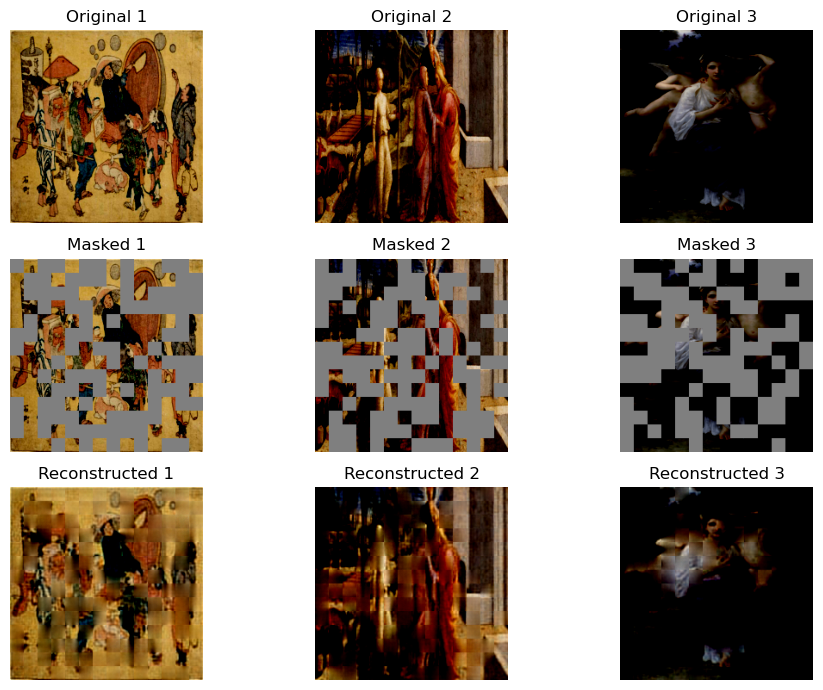

In [46]:
show_reconstructions(model_2, val_loader, num_images=3)

### MAE Model 3 (Implemented in `MAE_model_3.ipynb`)

In [23]:
# load model 3
model_3 = MAE(
    encoder_embed_dim=192,
    decoder_embed_dim=512,
    encoder_depth=12,
    decoder_depth=8,
    encoder_heads=3,
    decoder_heads=16,
).cuda()

checkpoint = torch.load(MODEL_3_PATH)
model_3.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [24]:
val_loss = evaluate_MAE(model_3, val_loader)

print(f"Validation Loss (MSE on masked regions): {val_loss:.4f}")

Validation Loss (MSE on masked regions): 0.4019


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


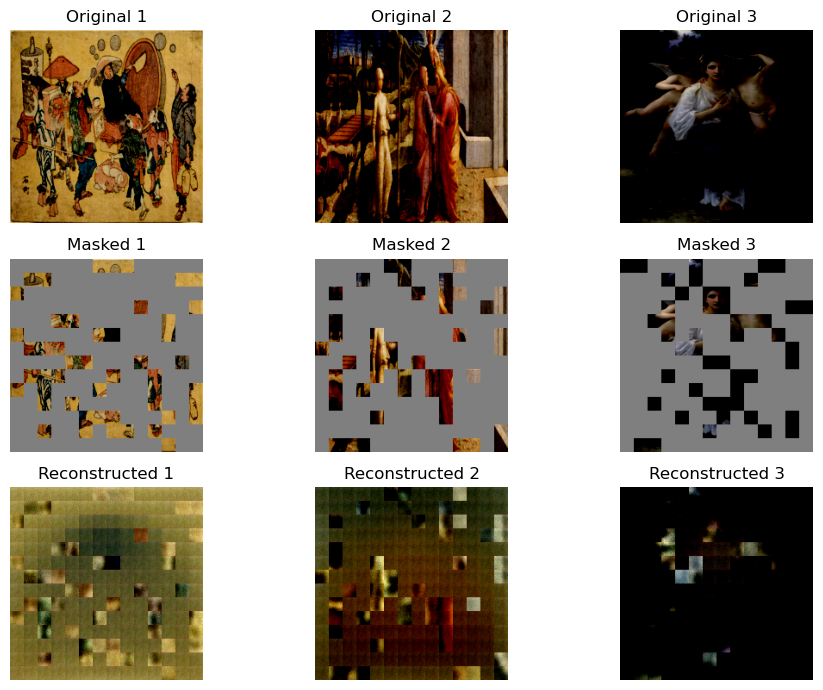

In [47]:
show_reconstructions(model_3, val_loader, num_images=3)

# Model Comparisons

### Loss Curve

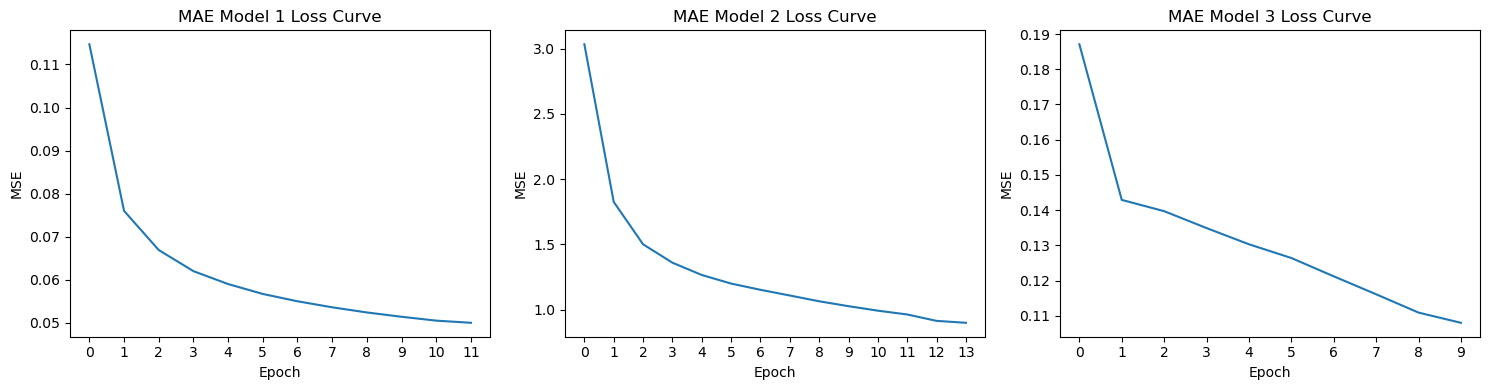

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i in range(1, 4):
    loss_df = pd.read_csv(f'data/model_loss/mae_model_{str(i)}.csv')
    
    ax = axes[i - 1]
    ax.plot(loss_df['epoch'], loss_df['loss'])
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE")
    ax.set_xticks(loss_df['epoch'])
    ax.set_title(f"MAE Model {i} Loss Curve")

plt.tight_layout()
plt.show()

### Learned Perceptual Image Patch Similarity (LPIPS)

In [27]:
import lpips

loss_fn = lpips.LPIPS(net='alex').cuda()
loss_fn.eval()

def calculate_lpips(model, data_loader):
    model.eval()
    total_lpips = 0.0
    total_samples = 0
    
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Evaluating LPIPS")
        
        for batch in progress_bar:
            images = batch[0].cuda(non_blocking=True)
            reconstructed, _ = model(images)
            
            # LPIPS requires images in [-1,1] range
            images = (images - 0.5) * 2
            reconstructed = (reconstructed - 0.5) * 2
            
            # Calculate LPIPS
            dist = loss_fn(images, reconstructed)
            total_lpips += dist.sum().item()
            total_samples += images.size(0)
            
            progress_bar.set_postfix({'LPIPS': total_lpips/total_samples})
    
    return total_lpips / total_samples

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: C:\Users\Kendrick Nguyen\.conda\envs\pytorch_practice\lib\site-packages\lpips\weights\v0.1\alex.pth


In [29]:
model_1_lpips_score = calculate_lpips(model_1, val_loader)
model_2_lpips_score = calculate_lpips(model_2, val_loader)
model_3_lpips_score = calculate_lpips(model_3, val_loader)

print(f"Model 1 LPIPS score: {model_1_lpips_score:.4f}")
print(f"Model 2 LPIPS score: {model_2_lpips_score:.4f}")
print(f"Model 3 LPIPS score: {model_3_lpips_score:.4f}")

Evaluating LPIPS: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [28:00<00:00,  5.58s/it, LPIPS=0.605]

Model 1 LPIPS score: 0.4107
Model 2 LPIPS score: 0.2965
Model 3 LPIPS score: 0.6054
